# Params

**Imports**

In [9]:
#pip install tqdm

In [10]:
#pip install torchvision

In [11]:
#pip install opencv-python

In [12]:
#pip install astropy

In [44]:
#pip install -U notebook-as-pdf


In [147]:
#Download
     #tqdm
     #torchvision
     #cv2   
#Pytorch dataset 
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader
from astropy.io import fits
import numpy as np
import random

#Deep Learning
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.utils import save_image
#images#
import cv2
import os
from matplotlib import pyplot as plt

# Drive
#from google.colab import drive
#drive.mount('/content/drive')

**Params Images**

In [148]:
N = 28 # image size
N_PSF = 28 # psf size
TYPE_PSF = 'gauss_28x28' 

**Params Dataset Python**


In [169]:
PATH = 'dataset/images_'+str(N)+'x'+str(N)+'_'+TYPE_PSF+'/images' #path where the dataset is saved 
PATH = 'dataset/images_'+str(N)+'x'+str(N)+'_'+TYPE_PSF+'/images' #path where the dataset is saved 
INITIAL_DATASET = 0  #initial index for the names of the saved images 
FINAL_DATASET =   100000#final index for the names of the saved images 
PERC_TRAIN = 0.7 # (70%) #training percentage 
PERC_TEST =  0.3 # (30%) #testing percentag
BATCH = 10 #batch sizeimages

**Params Dataset Python**


In [170]:
NUM_EPOCHS = 10
LEARNING_RATE = 1e-3
PATH_TRAIN =  'dataset/images_'+str(N)+'x'+str(N)+'_'+TYPE_PSF+'/train'
PATH_TEST =  'dataset/images_'+str(N)+'x'+str(N)+'_'+TYPE_PSF+'/test'
PATH_GRAPH = 'dataset/images_'+str(N)+'x'+str(N)+'_'+TYPE_PSF+'/graph'

**Auxiliary functions**

TODO: comentar

In [171]:
def save_decoded_image(img, name):
    img = img.view(img.size(0), 1, N, N)
    save_image(img, name)

TODO: comentar

In [172]:
def display_two(a, b, title1 = "Original", title2 = "Edited"):
    plt.subplot(121), plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(b), plt.title(title2)
    plt.xticks([]), plt.yticks([])
    plt.show()
    
# Display one image
def display(a, title1 = "Original"):
    plt.imshow(a), plt.title(title1)
    plt.show()

display fit image from a directory

In [173]:
def display_fits(path):
  hdul=fits.open(path)
  hdr = hdul[0].header
  size = hdr[3]
  data = hdul[0].data.astype(np.float32)
  image = np.reshape(data,[size,size])
  plt.imshow(image)

read fit image dataset from a directory


*   `path`: path where the images are
*   `type_image`: *image* (simulated images) or *conv* (dirty images)
*   `size_image`: TODO: comentar
*   `initial`: initial index for the names of the saved images
*   `final`: final index for the names of the saved images

In [174]:
def get_dataset(path,type_image,size_image,initial,final):
  images = []
  #path_file = path+'/'+type_image+'_'+str(size_image)+'x'+str(size_image)+'_'+str(initial)+'.fits'
  #hdul=fits.open(path_file)  
  #hdr = hdul[0].header
  #size = hdr[3]
  for i in range(initial,final):
    path_file = path+'/'+type_image+'_'+str(size_image)+'x'+str(size_image)+'_'+str(i)+'.fits'
    hdul=fits.open(path_file)
    data = hdul[0].data.astype(np.float32)
    image = np.reshape(data,[size_image,size_image])
    images.append(image)
  return images

Function which makes a directory `path`.

In [175]:
def make_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

TODO:borrar

In [176]:
def gauss(tamX,tamY,div):
  x, y = np.meshgrid(np.linspace(-1,1,tamX), np.linspace(-1,1,tamY))
  d = np.sqrt(x*x+y*y)
  sigma, mu = 1/div, 0.0
  gauss = np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )
  return gauss

# Pytorch Dataset

**Params**

In [177]:
size = FINAL_DATASET- INITIAL_DATASET  #size of lot of the dataset
size_train = round(size*PERC_TRAIN) 
size_test =  round(size*PERC_TEST)  
batch_size=  BATCH 
data_image = get_dataset(PATH,'image',N,INITIAL_DATASET,FINAL_DATASET)
data_dirty  = get_dataset(PATH,'conv',N_PSF,INITIAL_DATASET,FINAL_DATASET)

TODO: Comentar como en tutorial (DATAset create)

In [178]:
class interferometryDataset(Dataset):
  def __init__(self,datasetnoised,datasetclean,transform):
    self.noise=datasetnoised
    self.clean=datasetclean
    self.transform=transform
  
  def __len__(self):
    return len(self.noise)
  
  def __getitem__(self,idx):
    xNoise=self.noise[idx]
    xClean=self.clean[idx]
    
    if self.transform != None:
      xNoise=self.transform(xNoise)
      xClean=self.transform(xClean)

    return (xNoise,xClean)

we define the transforms for the images of dataset.

In [179]:
tsfms=transforms.Compose([
    transforms.ToTensor()
])

we divide the images into training and test sets

In [180]:
train_dirty = data_dirty[0:size_train]
train_images = data_image[0:size_train]

test_dirty = data_dirty[size_train:size_train+size_test]
test_image = data_image[size_train:size_train+size_test]

we generate the dataset using `Dataloard` that eases the task of making iterable training and testing sets. 

In [181]:
trainset=interferometryDataset(train_dirty,train_images,tsfms)
testset=interferometryDataset(test_dirty,test_image,tsfms)
trainloader=DataLoader(trainset,batch_size,shuffle=True)
testloader=DataLoader(testset,batch_size,shuffle=True)

# Deep Learning

**Auxiliary functions**

returns the CUDA GPU device or the CPU depending upon the availability. 

In [182]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

TODO: Comentar

In [183]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder layers
        self.enc1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.enc2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.enc3 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.enc4 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # decoder layers
        self.dec1 = nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2)  
        self.dec2 = nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2)
        self.dec3 = nn.ConvTranspose2d(16, 32, kernel_size=2, stride=2)
        self.dec4 = nn.ConvTranspose2d(32, 64, kernel_size=2, stride=2)
        self.out = nn.Conv2d(64, 1, kernel_size=3, padding=1)
    def forward(self, x):
        # encode
        x = F.relu(self.enc1(x))
        x = self.pool(x)
        x = F.relu(self.enc2(x))
        x = self.pool(x)
        x = F.relu(self.enc3(x))
        x = self.pool(x)
        x = F.relu(self.enc4(x))
        x = self.pool(x) # the latent space representation
        
        # decode
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.sigmoid(self.out(x))
        return x
net = Autoencoder()


TODO_ comentar

In [184]:
criterion = nn.MSELoss()
# the optimizaater
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

TODO_ comentar

In [185]:
def train(net, trainloader, NUM_EPOCHS,path):
    train_loss = []
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for dirty,clean in tqdm((trainloader)):
            dirty,clean=dirty.to(device),clean.to(device)
            optimizer.zero_grad()            
            outputs = net(dirty)
            loss = criterion(outputs, clean)
            # backpropagation
            loss.backward()
            # update the parameters
            optimizer.step()
            running_loss += loss.item()
        loss = running_loss / len(trainloader)
        train_loss.append(loss)
        print('Epoch {} of {}, Train Loss: {:.3f}'.format(
            epoch+1, NUM_EPOCHS, loss))
        save_decoded_image(dirty.cpu().data, name='./'+path+'/noisy{}.png'.format(epoch))
        save_decoded_image(outputs.cpu().data, name='./'+path+'/denoised{}.png'.format(epoch))
        save_decoded_image(clean.cpu().data, name='./'+path+'/clean{}.png'.format(epoch))
    return net,train_loss

In [186]:
def test_image_reconstruction(net, trainloader, NUM_EPOCHS,path):
    train_loss = []
    pnsr_1_list = []
    pnsr_2_list = []
    pnsr_3_list = []
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for dirty,clean in tqdm((trainloader)):
            dirty,clean=dirty.to(device),clean.to(device)
            optimizer.zero_grad()            
            outputs = net(dirty)
            loss = criterion(outputs, clean)
            # backpropagation
            loss.backward()
            # update the parameters
            optimizer.step()
            running_loss += loss.item()
        loss = running_loss / len(trainloader)
        train_loss.append(loss)
        print('Epoch {} of {}, Train Loss: {:.3f}'.format(
            epoch+1, NUM_EPOCHS, loss))
        ### to cpu ##
        dirty  = dirty.cpu().data
        outputs = outputs.cpu().data
        clean = clean.cpu().data 
        # psnr #
        psnr_1 = cv2.PSNR(np.array(clean), np.array(outputs))
        psnr_2 = cv2.PSNR(np.array(clean), np.array(dirty))
        psnr_3 = cv2.PSNR(np.array(dirty), np.array(outputs))
        pnsr_1_list.append(psnr_1)
        pnsr_2_list.append(psnr_2)
        pnsr_3_list.append(psnr_3)
        ####################
        save_decoded_image(dirty, name='./'+path+'/noisy{}.png'.format(epoch))
        save_decoded_image(outputs, name='./'+path+'/denoised{}.png'.format(epoch))
        save_decoded_image(clean, name='./'+path+'/clean{}.png'.format(epoch))
    return net,train_loss,pnsr_1_list,pnsr_2_list,pnsr_3_list

TODO_ comentar

In [187]:
device = get_device()
print(device)
net.to(device)


cpu


Autoencoder(
  (enc1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dec1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (dec2): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
  (dec3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (dec4): ConvTranspose2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
  (out): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

TODO_ comentar

  0%|          | 4/7000 [00:00<03:49, 30.48it/s]

Epoch 1 of 10, Train Loss: 0.012


  0%|          | 3/7000 [00:00<03:58, 29.38it/s]

Epoch 2 of 10, Train Loss: 0.003


  0%|          | 4/7000 [00:00<03:53, 29.95it/s]

Epoch 3 of 10, Train Loss: 0.003


  0%|          | 4/7000 [00:00<03:15, 35.71it/s]

Epoch 4 of 10, Train Loss: 0.003


  0%|          | 4/7000 [00:00<03:04, 37.98it/s]

Epoch 5 of 10, Train Loss: 0.003


  0%|          | 4/7000 [00:00<02:58, 39.09it/s]

Epoch 6 of 10, Train Loss: 0.003


  0%|          | 4/7000 [00:00<03:45, 31.03it/s]

Epoch 7 of 10, Train Loss: 0.003


  0%|          | 4/7000 [00:00<03:07, 37.22it/s]

Epoch 8 of 10, Train Loss: 0.002


  0%|          | 4/7000 [00:00<03:03, 38.21it/s]

Epoch 9 of 10, Train Loss: 0.002


100%|██████████| 7000/7000 [02:35<00:00, 45.01it/s]


Epoch 10 of 10, Train Loss: 0.002


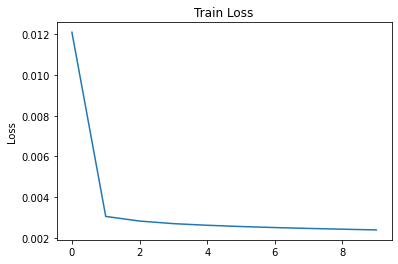

In [188]:
make_dir(PATH_TRAIN)
make_dir(PATH_GRAPH)
net,train_loss = train(net, trainloader, NUM_EPOCHS,PATH_TRAIN)
plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.ylabel('Loss')
plt.savefig(PATH_GRAPH+'/graph_loss_train.png')

In [189]:
print("finalized")

finalized


TODO_ comentar

  0%|          | 5/3000 [00:00<01:10, 42.55it/s]

Epoch 1 of 10, Train Loss: 0.002


  0%|          | 5/3000 [00:00<01:10, 42.53it/s]

Epoch 2 of 10, Train Loss: 0.002


  0%|          | 5/3000 [00:00<01:10, 42.38it/s]

Epoch 3 of 10, Train Loss: 0.002


  0%|          | 5/3000 [00:00<01:12, 41.42it/s]

Epoch 4 of 10, Train Loss: 0.002


  0%|          | 4/3000 [00:00<01:15, 39.50it/s]

Epoch 5 of 10, Train Loss: 0.002


  0%|          | 5/3000 [00:00<01:09, 43.28it/s]

Epoch 6 of 10, Train Loss: 0.002


  0%|          | 5/3000 [00:00<01:12, 41.26it/s]

Epoch 7 of 10, Train Loss: 0.002


  0%|          | 5/3000 [00:00<01:09, 43.26it/s]

Epoch 8 of 10, Train Loss: 0.002


  0%|          | 5/3000 [00:00<01:05, 46.04it/s]

Epoch 9 of 10, Train Loss: 0.002


100%|██████████| 3000/3000 [01:03<00:00, 46.90it/s]


Epoch 10 of 10, Train Loss: 0.002


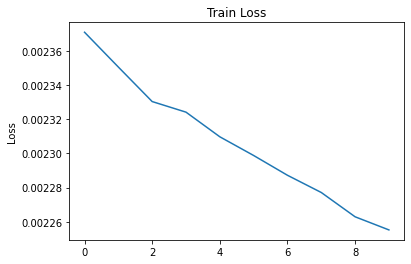

In [190]:
make_dir(PATH_TEST) 
#graphs = test_image_reconstruction(net, testloader,PATH_TEST)
net,test_loss,pnsr_1_list,pnsr_2_list,pnsr_3_list = test_image_reconstruction(net, testloader, NUM_EPOCHS,PATH_TEST)
plt.figure()
plt.plot(test_loss)
plt.title('Train Loss')
plt.ylabel('Loss')
plt.savefig(PATH_GRAPH+'/graph_loss_test.png')

In [191]:
print("finalized")

finalized


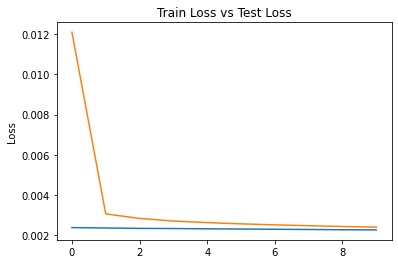

In [192]:
plt.figure()
plt.plot(test_loss)
plt.plot(train_loss)
plt.title('Train Loss vs Test Loss')
plt.ylabel('Loss')
plt.savefig(PATH_GRAPH+'/graph_loss_test_train.png')

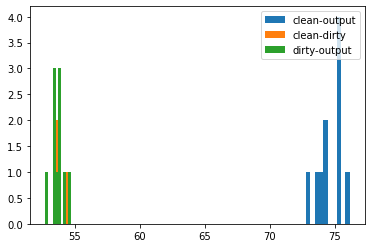

In [193]:
plt.hist(pnsr_1_list,  linewidth=1, label ='clean-output')
plt.hist(pnsr_2_list,  linewidth=1, label = 'clean-dirty')
plt.hist(pnsr_3_list, linewidth=1, label = 'dirty-output')
plt.legend(loc='upper right')
plt.savefig(PATH_GRAPH+'/graph_psnr.png')
plt.show()




# Resumen

**Image 28x28 & PSF Gauss 28x28**


**info image**: image size = 28x28, psf size = 28x28, type psf = gauss, dirty size = 28x28

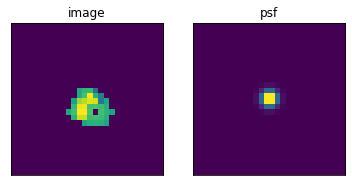

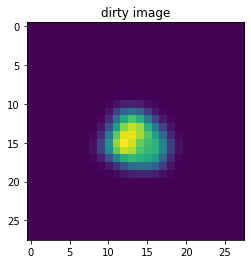

In [194]:
psf =gauss(28,28,14)
display_two(data_image[0],psf,'image','psf')
display(data_dirty[0],'dirty image')


**Info Dataset**:
size dataset = 100.000,
batch = 10,
train percentage = 70%,
test percentage = 30%

**Info Neural Network**: number of epochs = 15, learning rate = 1e-3

In [195]:
print(net)

Autoencoder(
  (enc1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dec1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (dec2): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
  (dec3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (dec4): ConvTranspose2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
  (out): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


**Info Results**

Train Loss vs Epoch

Text(0, 0.5, 'Loss')

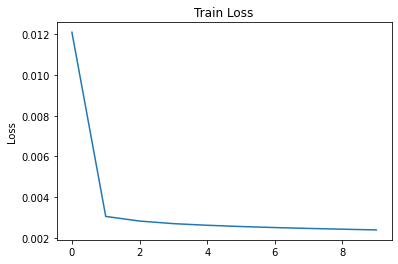

In [201]:
plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.ylabel('Loss')

Test Loss vs Epoch

Text(0, 0.5, 'Loss')

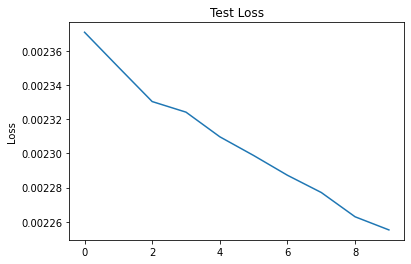

In [199]:
plt.figure()
plt.plot(test_loss)
plt.title('Test Loss')
plt.ylabel('Loss')

Train loss vs Test loss

Text(0, 0.5, 'Loss')

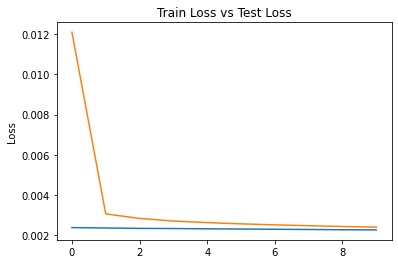

In [196]:
plt.figure()
plt.plot(test_loss)
plt.plot(train_loss)
plt.title('Train Loss vs Test Loss')
plt.ylabel('Loss')

pnsr of the images in each epoch

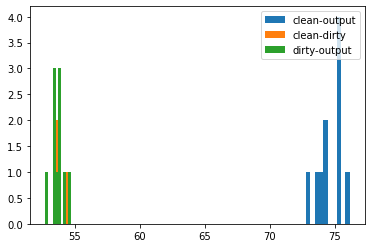

In [197]:
plt.hist(pnsr_1_list,  linewidth=1, label ='clean-output')
plt.hist(pnsr_2_list,  linewidth=1, label = 'clean-dirty')
plt.hist(pnsr_3_list, linewidth=1, label = 'dirty-output')
plt.legend(loc='upper right')
plt.show()

EPOCH: 0


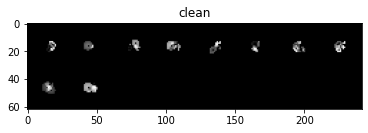

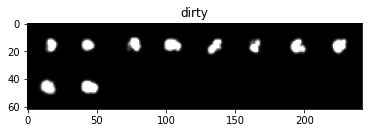

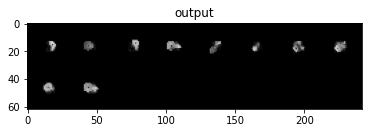

EPOCH: 1


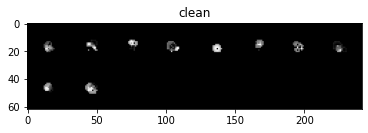

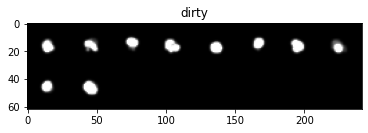

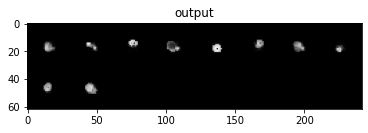

EPOCH: 2


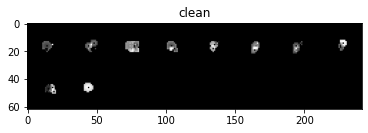

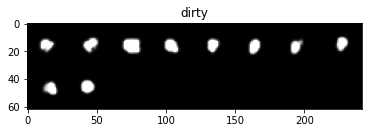

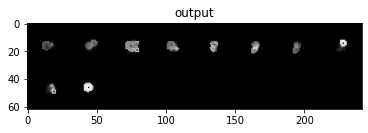

EPOCH: 3


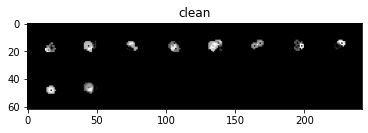

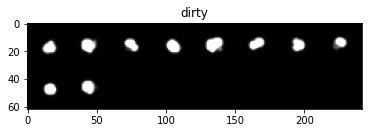

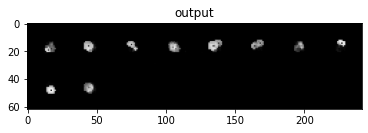

EPOCH: 4


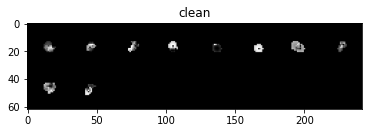

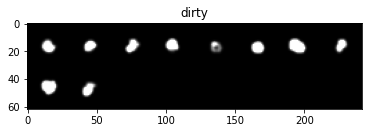

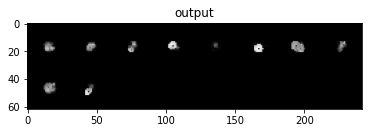

EPOCH: 5


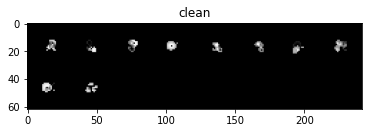

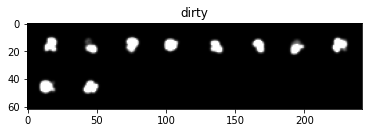

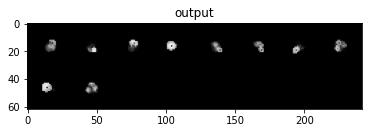

EPOCH: 6


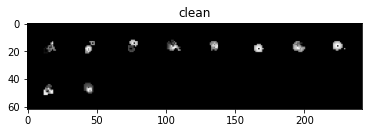

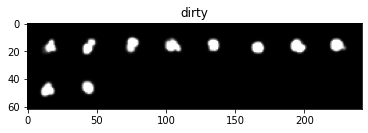

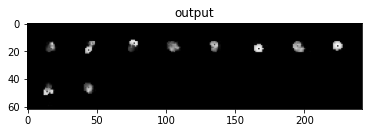

EPOCH: 7


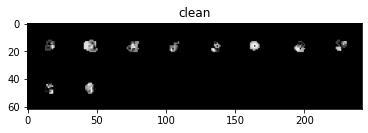

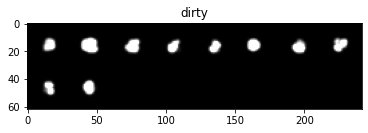

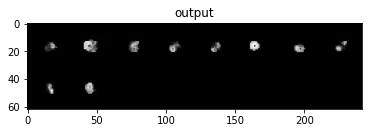

EPOCH: 8


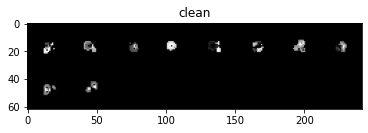

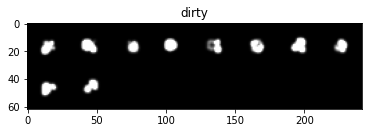

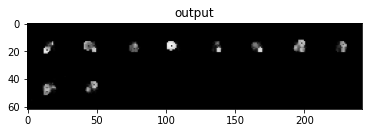

EPOCH: 9


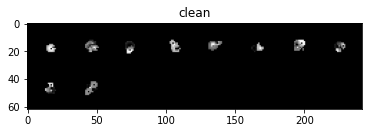

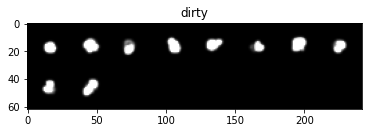

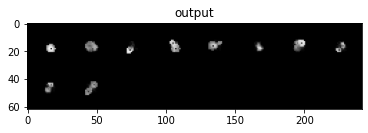

In [224]:
# Read image
for i in range(0,NUM_EPOCHS):
    clean = cv2.imread(PATH_TEST+'/clean'+str(i)+'.png')
    dirty = cv2.imread(PATH_TEST+'/noisy'+str(i)+'.png')
    output =  cv2.imread(PATH_TEST+'/denoised'+str(i)+'.png')
    print('EPOCH: '+str(i))
    display(clean,'clean')
    display(dirty,'dirty')
    display(output,'output')